In [1]:
import pandas as pd
from numpy.random import choice
import numpy as np
import matplotlib.pyplot as plt
import itertools
colors = ['r', 'g', 'b', 'y', 'black']

In [20]:
points = pd.read_csv('blobs.csv').as_matrix()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


**Task 1**

In [49]:
def ini_clusters(points, k=5): 
    centers = [np.random.randint(len(points))]
    nearest = np.array([[np.linalg.norm(points[centers[-1]]-points[i])**2, centers[-1]] if i not in centers
           else [0, centers[-1]] for i in range(len(points))])
    while len(centers) < k:
        dsum = sum([i[0] for i in nearest])
        centers.append(choice(list(range(len(points))), 1, p=[i[0]/dsum for i in nearest])[0])
        for i in range(len(points)): 
            if i in centers:
                nearest[i] = [0, i]
            else:
                r = np.linalg.norm(points[centers[-1]]-points[i])**2
                if r < nearest[i][0]:
                    nearest[i] = [r, centers[-1]] 
    return centers, nearest

In [50]:
def to_inx(centers, nearests):
    near = []
    for _, j in nearests:
        near.append(centers.index(j))
    return near

In [51]:
def calc_c_mass(points, nears, k, dim=2):
    clusters = {i: [] for i in range(k)}
    c_mass = []
    for num, ne in enumerate(nears):
        clusters[ne].append(num)
    for key, item in clusters.items():
        c_m = np.array([0 for _ in range(dim)])
        for it in item:
            c_m = c_m + points[it]
        c_m = c_m / len(item)
        c_mass.append(c_m)    
    return c_mass

In [52]:
def calc_belongs(points, xy_centers):
    belongs = []
    for point in points:
        distances = []
        for center in xy_centers:
            distances.append(np.linalg.norm(point-center))
        belongs.append(np.argmin(distances))
    return belongs

In [53]:
def k_means(points, k=1, dim=2):
    centroids, nears = ini_clusters(points, k=k)
    nears = to_inx(centroids, nears)
    # how check migrations: for example, look at center mass shift by this code uses magic constant 100 iterations
    # It works (may be it needs some runs) because it has yet random in first point choice
    for _ in range(100):
        centers_mass = calc_c_mass(points, nears, k, dim=dim)
        nears = calc_belongs(points, centers_mass)
    return nears

Text(0.5, 1.0, 'k-means, 2 classes')

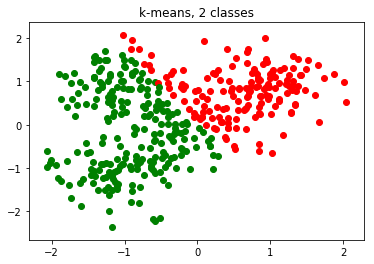

In [54]:
ns = k_means(points, 2)
for point, c in zip(points, ns): plt.scatter(point[0], point[1], color=colors[int(c)])
plt.title('k-means, 2 classes')

Text(0.5, 1.0, 'k-means, 3 classes')

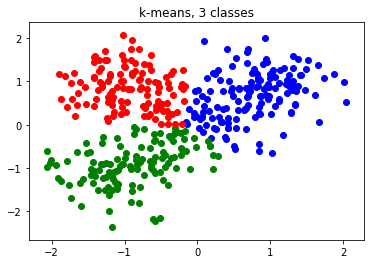

In [55]:
ns = k_means(points, 3)
for point, c in zip(points, ns): plt.scatter(point[0], point[1], color=colors[c])
plt.title('k-means, 3 classes')

Text(0.5, 1.0, 'k-means, 4 classes')

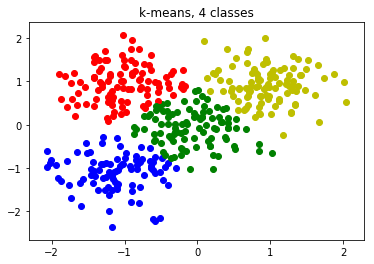

In [56]:
ns = k_means(points, 4)
for point, c in zip(points, ns): plt.scatter(point[0], point[1], color=colors[c])
plt.title('k-means, 4 classes')

Text(0.5, 1.0, 'k-means, 5 classes')

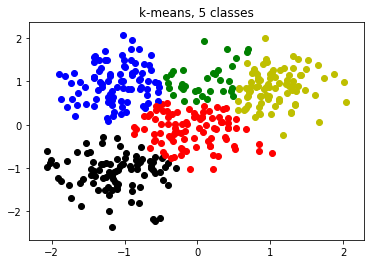

In [57]:
ns = k_means(points, 5)
for point, c in zip(points, ns): plt.scatter(point[0], point[1], color=colors[c])
plt.title('k-means, 5 classes')

**Task 2**

In [304]:
def neighbors(points, inx, eps):
    ns = []
    for en, point in enumerate(points):
        if np.linalg.norm(point-points[inx]) < eps:
            ns.append(en)
    ns.remove(inx)
    return ns

def dbscan(points, eps, nn):
    labels = [-1 for _ in range(len(points))] # -1 - undefined, -2 - alone
    clasters_count = 0
    for i in range(len(points)):
        if labels[i] != -1: continue
        ns = neighbors(points, i, eps)
        if len(ns) < nn:
            labels[i] = -2
            continue
        clasters_count += 1
        labels[i] = clasters_count
        for j in ns:
            if labels[j] == -2: labels[j] = clasters_count
            elif labels[j] != -1: continue
            labels[j] = clasters_count
            cur_ns = neighbors(points, j, eps)
            if len(cur_ns) >= nn:
                [ns.append(nei) for nei in cur_ns]
    return labels

{1, 2, 3, 4, -2}


Text(0.5,1,'DBSCAN, 4 classes')

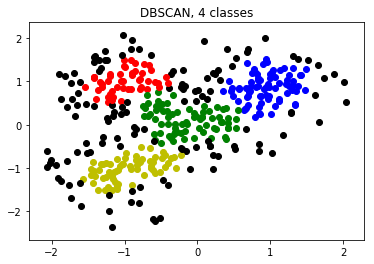

In [340]:
ls = dbscan(points, 0.3, 17)
speial_colors = ['black', 'g', 'y', 'b', 'r', 'black', 'black'] # because of -2 index of alone point
print(set(ls))
for point, c in zip(points, ls): plt.scatter(point[0], point[1], color=speial_colors[c])
plt.title('DBSCAN, 4 classes') #black ones haven't cluster

**Task 3**

In [241]:
def find_distance(points, clusters, c1, c2):
    d = 0
    for inx1 in clusters[c1]:
        for inx2 in clusters[c2]:
            d = max(d, np.linalg.norm(points[inx1]-points[inx2]))
    return d

def best_pair(points, clusters): #minimax
    labels = list(clusters.keys())
    opt_distance = np.inf
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            r = find_distance(points, clusters, labels[i], labels[j])
            if r < opt_distance:
                opt_distance = r
                i0, i1 = labels[i], labels[j]
    return i0, i1

def merge_clusters(clusters, c1, c2):
    for i in clusters[c2]:
        clusters[c1].append(i)
    clusters.pop(c2)
    return clusters

def agglomerative(points, num_clusters):
    clusters = {i: [i] for i in range(len(points))}
    while len(clusters) > num_clusters:
        pair = best_pair(points, clusters)
        merge_clusters(clusters, *pair)
    return clusters

Text(0.5,1,'Agglomerate, 2 classes')

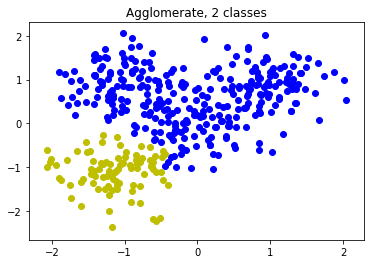

In [242]:
aggl2 = agglomerative(points, 2)
aggl2.keys()
lazy_colors = ['b', 'b', 'y', 'g', 'r', 'r']
for key, item in aggl2.items():
    for point in item:
        plt.scatter(points[point][0], points[point][1], color=lazy_colors[key])
plt.title('Agglomerate, 2 classes')

Text(0.5,1,'Agglomerate, 3 classes')

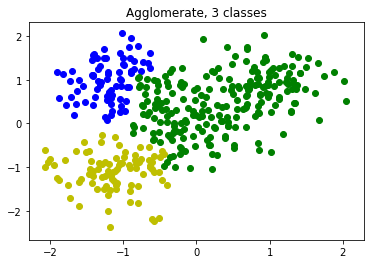

In [243]:
aggl3 = agglomerative(points, 3)
aggl3.keys()
lazy_colors = ['b', 'b', 'y', 'g', 'r', 'r']
for key, item in aggl3.items():
    for point in item:
        plt.scatter(points[point][0], points[point][1], color=lazy_colors[key])
plt.title('Agglomerate, 3 classes')

In [244]:
aggl = agglomerative(points, 4)

Text(0.5,1,'Agglomerate, 4 classes')

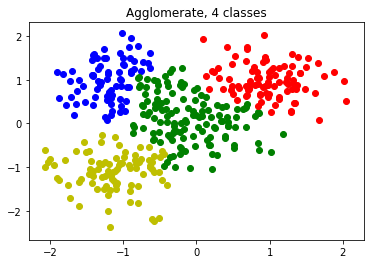

In [247]:
aggl.keys()
lazy_colors = ['b', 'b', 'y', 'g', 'r', 'r']
for key, item in aggl.items():
    for point in item:
        plt.scatter(points[point][0], points[point][1], color=lazy_colors[key])
plt.title('Agglomerate, 4 classes')

In [248]:
aggl = agglomerative(points, 5)

dict_keys([0, 2, 3, 5, 13])


Text(0.5,1,'Agglomerate, 5 classes')

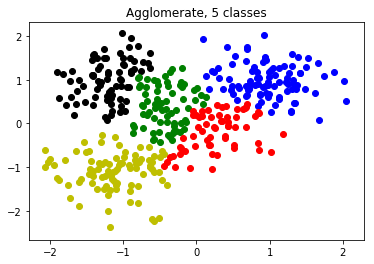

In [253]:
print(aggl.keys())
lazy_colors = ['black', 'b', 'y', 'g', 'r', 'blue', 'b','b','b','b','b','b','b','r']
for key, item in aggl.items():
    for point in item:
        plt.scatter(points[point][0], points[point][1], color=lazy_colors[key])
plt.title('Agglomerate, 5 classes')

**Task 4**

In [8]:
spam = pd.read_csv('spam.csv')
spam_ans = spam.pop('label')
points_spam = spam.as_matrix()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
def purity(clusters, answers):
    clust = [i for i in clusters]
    counter = [[0, 0] for _ in range(len(set(clust)))]
    for i in range(len(clust)):
        counter[clust[i]][answers[i]] += 1
    return sum([max(i) for i in counter])/len(answers)

Text(0.5, 1.0, 'Dependence purity on clusters number (without normalize)')

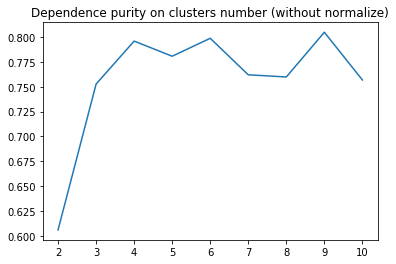

In [58]:
x = list(range(2, 11))
y = [purity(k_means(points_spam, k=i, dim=len(points_spam[0])), spam_ans) for i in x]
plt.plot(x, y)
plt.title('Dependence purity on clusters number (without normalize)')

In [59]:
def normalize(dataset):
    mins = [min(dataset.T[inx]) for inx in range(len(dataset[0]))]
    for i in range(len(dataset)):
        for j in range(len(dataset[0])):
            dataset[i][j] -= mins[j]
    maxs = [max(dataset.T[inx]) for inx in range(len(dataset[0]))]
    for i in range(len(dataset)):
        for j in range(len(dataset[0])):
            dataset[i][j] /= maxs[j]    
    return dataset

mn_spam = normalize(points_spam)

Text(0.5, 1.0, 'Dependence purity on clusters number (with normalize)')

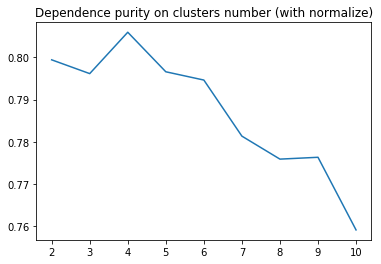

In [60]:
x = list(range(2, 11))
y = [purity(k_means(mn_spam, k=i, dim=len(mn_spam[0])), spam_ans) for i in x]
plt.plot(x, y)
plt.title('Dependence purity on clusters number (with normalize)')